## Deep learning

In [2]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [2]:
%matplotlib inline

####  The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples.

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' 

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_small.tar.gz


In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for .\notMNIST_large. This may take a while. Please wait.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
Extracting data for .\notMNIST_small. This may take a while. Please wait.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


#### might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size. <br/>
#### We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.<br/>
#### A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling .\notMNIST_large\A.pickle.
.\notMNIST_large\A
Could not read: .\notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: .\notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: .\notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825024
Standard deviation: 0.44312063
Pickling .\notMNIST_large\B.pickle.
.\notMNIST_large\B
Could not read: .\notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.0075630303
Standard deviation: 0.45449105
Pickling .\notMNIST_large\C.pickle.
.\notMNIST_large\C
Full dataset tensor: (52912, 

In [6]:
os.listdir("notMNIST_small")

['A',
 'A.pickle',
 'B',
 'B.pickle',
 'C',
 'C.pickle',
 'D',
 'D.pickle',
 'E',
 'E.pickle',
 'F',
 'F.pickle',
 'G',
 'G.pickle',
 'H',
 'H.pickle',
 'I',
 'I.pickle',
 'J',
 'J.pickle']

In [7]:
os.listdir("notMNIST_small/A")

['MDEtMDEtMDAudHRm.png',
 'MDRiXzA4LnR0Zg==.png',
 'MjAwcHJvb2Ztb29uc2hpbmUgcmVtaXgudHRm.png',
 'MlJlYmVsc0RldXgtQmxhY2sub3Rm.png',
 'MlRvb24gU2hhZG93LnR0Zg==.png',
 'MlRvb24yIFNoYWRvdy50dGY=.png',
 'MTAuMTUgU2F0dXJkYXkgTmlnaHQgQlJLLnR0Zg==.png',
 'MTFTMDEgQmxhY2sgVHVlc2RheSBPZmZzZXQudHRm.png',
 'MTggSG9sZXMgQlJLLnR0Zg==.png',
 'MTh0aENlbnR1cnkudHRm.png',
 'MTIgV2FsYmF1bSBJdGFsaWMgMTMyNjMudHRm.png',
 'MTJTYXJ1WWVsbG93Rm9nLnR0Zg==.png',
 'Nng3b2N0IEFsdGVybmF0ZSBFeHRyYUxpZ2h0LnR0Zg==.png',
 'Nng3b2N0IEFsdGVybmF0ZSBSZWd1bGFyLnR0Zg==.png',
 'NXRoR3JhZGVyLnR0Zg==.png',
 'OC1iaXQgTGltaXQgTyBCUksudHRm.png',
 'OEJhbGxTY3JpcHRTQ2Fwc1NTSyBJdGFsaWMudHRm.png',
 'OTExIFBvcnNjaGEgSXRhbGljLnR0Zg==.png',
 'OXNxZ3JkIFRoaW4udHRm.png',
 'Q09ERTNYLnR0Zg==.png',
 'Q0cgT21lZ2EudHRm.png',
 'Q0NDb21pY3JhenktQm9sZEl0YWxpYy50dGY=.png',
 'Q0NTcG9va3l0b290aC1SZWd1bGFyLnR0Zg==.png',
 'Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png',
 'Q0sgUGluay50dGY=.png',
 'Q1FOLU1vbGVjdWxhci1EeW5hbW8tUmVndWxhci5vdGY=.png',
 'Q290cmFu

### Display some images to check

In [8]:
display(Image(filename="notMNIST_small/A/Q291cmllciAxMCBQaXRjaCBJdGFsaWMucGZi.png"))

In [9]:
os.listdir("notMNIST_small/J")

['MDEtMDEtMDAudHRm.png',
 'MDRiXzA4LnR0Zg==.png',
 'MjAwcHJvb2Ztb29uc2hpbmUgcmVtaXgudHRm.png',
 'MlJlYmVsc0RldXgtQmxhY2sub3Rm.png',
 'MlRvb24gU2hhZG93LnR0Zg==.png',
 'MlRvb24yIFNoYWRvdy50dGY=.png',
 'MTAuMTUgU2F0dXJkYXkgTmlnaHQgQlJLLnR0Zg==.png',
 'MTFTMDEgQmxhY2sgVHVlc2RheSBPZmZzZXQudHRm.png',
 'MTggSG9sZXMgQlJLLnR0Zg==.png',
 'MTh0aENlbnR1cnkudHRm.png',
 'MTIgV2FsYmF1bSBJdGFsaWMgMTMyNjMudHRm.png',
 'MTJTYXJ1WWVsbG93Rm9nLnR0Zg==.png',
 'Nng3b2N0IEFsdGVybmF0ZSBFeHRyYUxpZ2h0LnR0Zg==.png',
 'Nng3b2N0IEFsdGVybmF0ZSBSZWd1bGFyLnR0Zg==.png',
 'NXRoR3JhZGVyLnR0Zg==.png',
 'OC1iaXQgTGltaXQgTyBCUksudHRm.png',
 'OEJhbGxTY3JpcHRTQ2Fwc1NTSyBJdGFsaWMudHRm.png',
 'OTExIFBvcnNjaGEgSXRhbGljLnR0Zg==.png',
 'OXNxZ3JkIFRoaW4udHRm.png',
 'Q09ERTNYLnR0Zg==.png',
 'Q0cgT21lZ2EudHRm.png',
 'Q0NDb21pY3JhenktQm9sZEl0YWxpYy50dGY=.png',
 'Q0NTcG9va3l0b290aC1SZWd1bGFyLnR0Zg==.png',
 'Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png',
 'Q0sgUGluay50dGY=.png',
 'Q1FOLU1vbGVjdWxhci1EeW5hbW8tUmVndWxhci5vdGY=.png',
 'Q290cmFu

In [11]:
display(Image(filename="notMNIST_small/J/MTJTYXJ1WWVsbG93Rm9nLnR0Zg==.png"))

### Check data under some label if can be displayed correctly

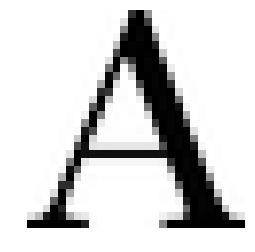

In [18]:
pickle_file = train_datasets[0]  # index 0 should be all As, 1 = all Bs, etc.
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f)  # unpickle
    sample_idx = np.random.randint(len(letter_set))  # pick a random image index
    sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
    plt.figure()
    plt.axis('off')
    plt.imshow(sample_image, cmap='Greys') 

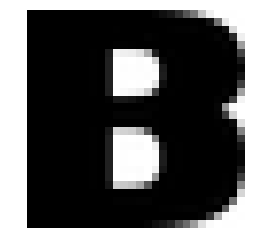

In [19]:
pickle_file = train_datasets[1]  # index 0 should be all As, 1 = all Bs, etc.
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f)  # unpickle
    sample_idx = np.random.randint(len(letter_set))  # pick a random image index
    sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
    plt.figure()
    plt.axis('off')
    plt.imshow(sample_image,cmap='Greys') 

### Check if the dataset is well balanced across the classes

In [21]:
for pickle_file in train_datasets:
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        print (pickle_file, len(letter_set))

.\notMNIST_large\A.pickle 52909
.\notMNIST_large\B.pickle 52911
.\notMNIST_large\C.pickle 52912
.\notMNIST_large\D.pickle 52911
.\notMNIST_large\E.pickle 52912
.\notMNIST_large\F.pickle 52912
.\notMNIST_large\G.pickle 52912
.\notMNIST_large\H.pickle 52912
.\notMNIST_large\I.pickle 52912
.\notMNIST_large\J.pickle 52911


#### Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

In [22]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


#### Randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [23]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

#### Save the data for later reuse:

In [24]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [25]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


In [46]:
train_dataset.shape

(200000, 28, 28)

In [48]:
train_dataset[1].shape

(28, 28)

### There might be duplicated data in the train dataset

In [53]:
a = train_dataset.reshape(200000,28*28)

np.unique(a, axis=0).shape


(187218, 784)

#### There are about 13000 duplicated images in the train set, actually we do not need to remove them

In [54]:
overlap = 0
for img in range(train_dataset.shape[0]):
    if np.equal(valid_dataset, train_dataset[img]).any(1).all():
       overlap += 1

print (overlap)


0


In [59]:
train_dataset_small=train_dataset[:20000].reshape(20000, 28*28)
train_labels_small= train_labels[:20000]

clf=LogisticRegression()
clf.fit(train_dataset_small,train_labels_small)
pred=clf.predict(test_dataset.reshape(-1, 28*28))


In [60]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred)

0.8737

## TensorFlow

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


#### Reformat into a shape that's more adapted to the models we're going to train:

- data as a flat matrix,
- labels as float 1-hot encodings.



In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [1]:
import tensorflow as tf

In [5]:
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants 
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy. We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [6]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 18.306660
Training accuracy: 6.9%
Validation accuracy: 8.5%
Loss at step 100: 2.322087
Training accuracy: 71.8%
Validation accuracy: 70.3%
Loss at step 200: 1.871662
Training accuracy: 75.0%
Validation accuracy: 72.5%
Loss at step 300: 1.633926
Training accuracy: 76.4%
Validation accuracy: 73.4%
Loss at step 400: 1.471250
Training accuracy: 77.1%
Validation accuracy: 73.8%
Loss at step 500: 1.348634
Training accuracy: 77.7%
Validation accuracy: 74.2%
Loss at step 600: 1.252040
Training accuracy: 78.5%
Validation accuracy: 74.2%
Loss at step 700: 1.173462
Training accuracy: 79.0%
Validation accuracy: 74.5%
Loss at step 800: 1.107775
Training accuracy: 79.4%
Validation accuracy: 74.5%
Test accuracy: 82.5%


#### SGD classifier

In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [8]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 21.421015
Minibatch accuracy: 7.0%
Validation accuracy: 10.7%
Minibatch loss at step 500: 1.203960
Minibatch accuracy: 78.9%
Validation accuracy: 75.4%
Minibatch loss at step 1000: 1.491076
Minibatch accuracy: 78.1%
Validation accuracy: 76.2%
Minibatch loss at step 1500: 0.713364
Minibatch accuracy: 83.6%
Validation accuracy: 77.1%
Minibatch loss at step 2000: 0.825522
Minibatch accuracy: 82.8%
Validation accuracy: 77.5%
Minibatch loss at step 2500: 0.905889
Minibatch accuracy: 79.7%
Validation accuracy: 77.8%
Minibatch loss at step 3000: 1.242106
Minibatch accuracy: 71.9%
Validation accuracy: 78.7%
Test accuracy: 86.5%


### Add hiden nodes with `relu` to improve accuracy

In [15]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
    
  # new hidden layer
  hidden_nodes = 1024
  hidden_weights = tf.Variable( tf.truncated_normal([image_size * image_size, hidden_nodes]) )
  hidden_biases = tf.Variable( tf.zeros([hidden_nodes]))
  hidden_layer = tf.nn.relu( tf.matmul( tf_train_dataset, hidden_weights) + hidden_biases)
  
  # Variables.
  weights = tf.Variable( tf.truncated_normal([hidden_nodes, num_labels])) 
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(hidden_layer, weights) + biases
  loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels) )
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_relu = tf.nn.relu(  tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
  valid_prediction = tf.nn.softmax( tf.matmul(valid_relu, weights) + biases) 

  test_relu = tf.nn.relu( tf.matmul( tf_test_dataset, hidden_weights) + hidden_biases)
  test_prediction = tf.nn.softmax(tf.matmul(test_relu, weights) + biases)

In [16]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 353.162231
Minibatch accuracy: 7.0%
Validation accuracy: 33.6%
Minibatch loss at step 500: 19.718578
Minibatch accuracy: 81.2%
Validation accuracy: 78.4%
Minibatch loss at step 1000: 13.065530
Minibatch accuracy: 80.5%
Validation accuracy: 80.6%
Minibatch loss at step 1500: 4.508101
Minibatch accuracy: 88.3%
Validation accuracy: 80.0%
Minibatch loss at step 2000: 3.736890
Minibatch accuracy: 84.4%
Validation accuracy: 80.5%
Minibatch loss at step 2500: 4.386206
Minibatch accuracy: 82.8%
Validation accuracy: 81.3%
Minibatch loss at step 3000: 1.832923
Minibatch accuracy: 85.2%
Validation accuracy: 81.6%
Test accuracy: 89.6%
